In [212]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# automatically refresh imported modules
%reload_ext autoreload
%autoreload 2

## for data
import json
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier


## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api
from sklearn import metrics

In [188]:
# for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [189]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [190]:
path3 = "/Users/victor/Documents/Confidential Dataset/ML_NOAC_NOVA_Extraction_Cleaned_DF3_Full.csv"
df = pd.read_csv(path3)
df.head()

,index,CaseNumber,Type,Topics,TeamName,RequesterEmail,EmailObject,LastEmailCCAddress,AttributesURL,ContactAttributesURL,ContactEmail,LastIncomingEmailContent,LastEmailCCAddressCount,CMA_in_cc,CountMailsInConversation,LastEmailContent
0,0,100124562,0,T039,US-NOR-CMA-BKG-PREFERRED,NaN,NAM4999926A,op@easywayintl.com,5005p00002evRjHAAU,0035p00003aZAdZAAW,usa.wcportops@cma-cgm.com,\nThank you Jessica! Await your further on th...,1,False,7,thank you jessica await your further on the tw...
1,1,100080371,0,T036,US-BNA-CMA-CS-IMP-DIVERSIONS,NaN,MOGELIJKE COD'S F119086 // RTM,janneke.van.leeuwen@fclmarine.nl; executivedes...,5005p00002evWsuAAE,0030N00003N771RQAR,janneke.van.leeuwen@fclmarine.nl,"\nHi Nese,\n \nInmiddels de aangepaste bl’s al...",5,True,4,hi nese inmiddels de aangepaste bls al beschik...
2,2,100095395,0,T035,US-NOR-CMA-BKG-PREFERRED,tina@generallogistics.net,AMEND NAM5088900 [ ref:_00D,bookings@generallogistics.net,5005p00002evX4SAAU,0030N00002x1JqPQAU,tina@generallogistics.net,"\nHello,\nPlease SPLIT subject line booking to...",1,False,3,hello please split subject line booking to the...
3,3,100097054,0,T847,US-NOR-CMA-BKG-SPECIALTY,bookings@delongcompany.com,FW: CMA CGM - Cut-off date cha,usa.cmaexportactive@usa.cma-cgm.com,5005p00002evXIsAAM,0030N00002tXvvIQAS,bookings@delongcompany.com,"CMA CGM - Cut-off date change at - NEW YORK, N...",1,True,2,cma cgm cutoff date change at new york ny u up...
4,4,100097055,0,T847,US-NOR-CMA-BKG-SPECIALTY,bookings@delongcompany.com,FW: CMA CGM - Cut-off date cha,NaN,5005p00002evXItAAM,0030N00002tXvvIQAS,bookings@delongcompany.com,"CMA CGM - Cut-off date change at - NEW YORK, N...",0,False,2,cma cgm cutoff date change at new york ny u up...


In [191]:
var_used = "EmailObject"
df = df[['Type', var_used]]
df.head()

,Type,EmailObject
0,0,NAM4999926A
1,0,MOGELIJKE COD'S F119086 // RTM
2,0,AMEND NAM5088900 [ ref:_00D
3,0,FW: CMA CGM - Cut-off date cha
4,0,FW: CMA CGM - Cut-off date cha


In [192]:
lst_stopwords = nltk.corpus.stopwords.words("english")

df["text_clean"] = df[var_used].progress_apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

100%|██████████| 251234/251234 [00:03<00:00, 71070.70it/s]


In [193]:
## split dataset
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

## get target
y_train = df_train["Type"].values
y_test = df_test["Type"].values


# BAG OF WORDS

In [194]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [195]:
corpus = df_train["text_clean"]

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [196]:
y = df_train["Type"]

X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()

for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))

    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])

    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    
X_names = dtf_features["feature"].unique().tolist()


In [197]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(

dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")


# 0:
  . selected features: 3989
  . top features: 20220301,20220302,20220303,20220304,20220307,20220309,20220310,20220315,ach,alert
 
# 1:
  . selected features: 3989
  . top features: 20220301,20220302,20220303,20220304,20220307,20220309,20220310,20220315,ach,alert
 


In [198]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)

vectorizer.fit(corpus)

X_train = vectorizer.transform(corpus)

dic_vocabulary = vectorizer.vocabulary_

In [218]:
def threshold(y_true, y_pred):

  pre, rec, t = precision_recall_curve(y_true, y_pred)

  # get threshold that allows for >95% precision
  return t[next(x for x, val in enumerate(pre) if val >= 0.7)]

# Naive Bayes Classifier

In [223]:

classifier = naive_bayes.MultinomialNB()

## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

MultinomialNB()

In [224]:
## test
# X_train = df_train["text_clean"].values
X_test = df_test["text_clean"].values

# make predictions
predicted_prob = model.predict_proba(X_test)

# understand threshold to have 95% precision
t = threshold(y_test, predicted_prob[:,1])

# translate probabilities into predictions
predicted = predicted_prob[:,1] > t

Accuracy: 0.75
Auc: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.76      0.92      0.84     51361
           1       0.70      0.39      0.50     24010

    accuracy                           0.75     75371
   macro avg       0.73      0.66      0.67     75371
weighted avg       0.74      0.75      0.73     75371



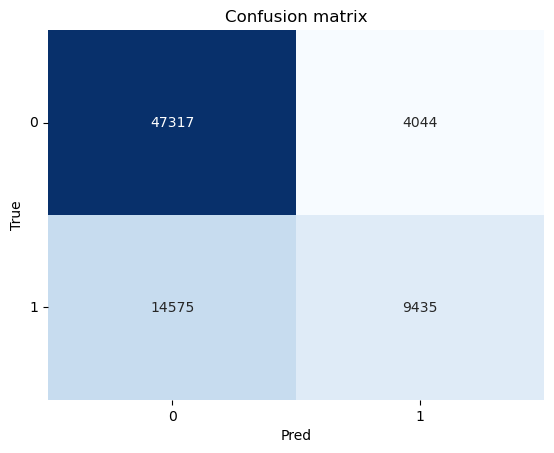

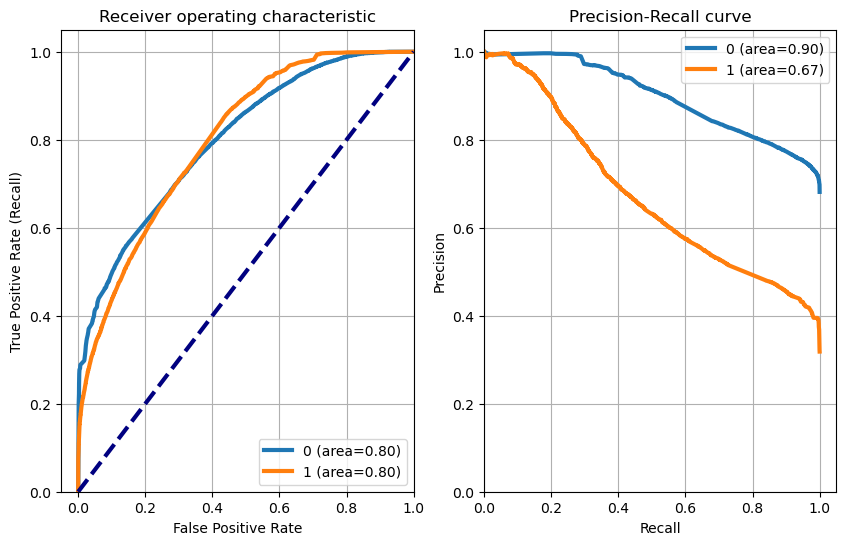

In [225]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
                            
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [226]:
## select observation
i = 3
txt_instance = df_test[var_used].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: 0 --> Pred: False | Prob: 1.0


# Random Forest Classifier

In [228]:
from sklearn.ensemble import RandomForestClassifier

## pipeline
classifier = RandomForestClassifier()

model_rf = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])

## train classifier
model_rf["classifier"].fit(X_train, y_train)

## test
X_test = df_test["text_clean"].values
predicted = model_rf.predict(X_test)
predicted_prob = model_rf.predict_proba(X_test)

KeyboardInterrupt: 

In [ ]:
# make predictions
predicted_prob = model_rf.predict_proba(X_test)

# understand threshold to have 95% precision
t = threshold(y_test, predicted_prob[:,1])

# translate probabilities into predictions
predicted = predicted_prob[:,1] > t

Accuracy: 0.78
Auc: 0.83
Detail:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85     51341
           1       0.74      0.47      0.57     24030

    accuracy                           0.78     75371
   macro avg       0.76      0.69      0.71     75371
weighted avg       0.77      0.78      0.76     75371



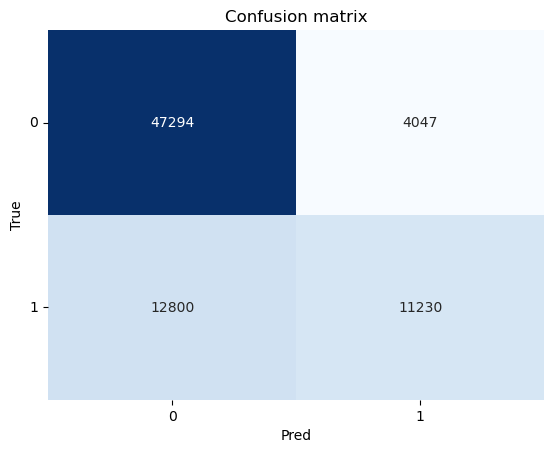

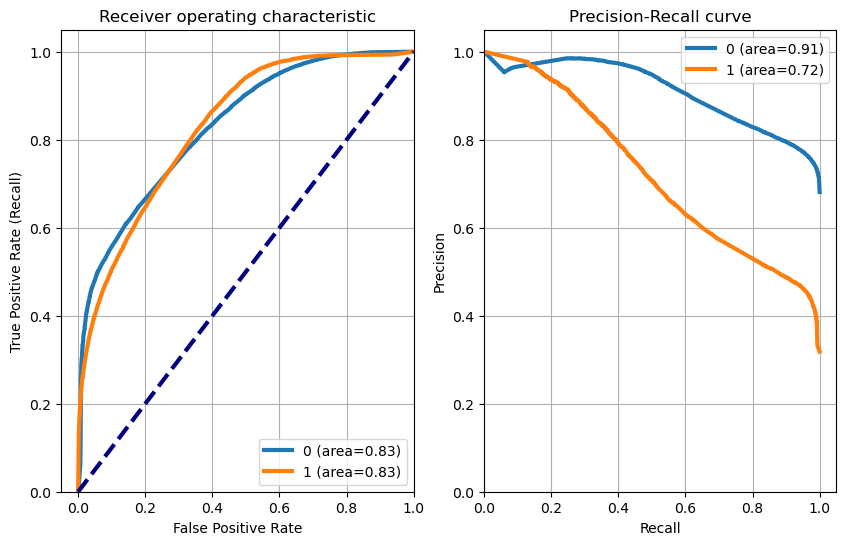

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
                            
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()